# Import Libraries

In [ ]:
!pip install tf-nightly
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Link the google drive images to the notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_folder = '/content/drive/My Drive/hymenoptera_data'
train_folder = os.path.join( data_folder, 'train' )
val_folder = os.path.join( data_folder, 'val')
test_folder = os.path.join( data_folder, 'test' )

# Data Augmentation

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
default_transform_list = [transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3)]
special_transform_list = [transforms.RandomPerspective(distortion_scale=0.5, p=0.2, interpolation=3, fill=0),transforms.RandomGrayscale(p=0.2)]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(120, resample= PIL.Image.BILINEAR, expand=False, center=None, fill=None),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply(default_transform_list, p=0.5),
        transforms.RandomChoice(special_transform_list),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_folder, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Model

In [ ]:
!pip install pkbar
import pkbar
import torch

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch: %d/%d' % (epoch + 1, num_epochs))
        kbar = pkbar.Kbar(target=num_epochs, width=8)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    kbar.update(epoch, values=[("loss", loss)])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # print(preds,end= '\n')
            # for j in range(inputs.size()[0]):
            #   print(class_names[preds[j]], end='\n')

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Choice: MobileNet

In [ ]:
import torch.nn as nn
# Pytorch pretrained model
import torchvision.models as models
model_ft = models.mobilenet_v2(pretrained=True, progress=True)
model_ft.classifier[1] = nn.Linear(model_ft.last_channel, 10)

Choice: Resnet

In [ ]:
#Run if want resnet
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

In [ ]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training the Model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)
save_model_path = os.path.join(data_folder, 'model.pth' )
torch.save(model_ft, save_model_path)

Epoch: 1/10
 0/10 [........] - ETA: 0s - loss: 0.0000e+00val Loss: 0.3556 Acc: 0.8431

Epoch: 2/10
 1/10 [........] - ETA: 49s - loss: 0.5694val Loss: 0.2731 Acc: 0.9216

Epoch: 3/10
 2/10 [>.......] - ETA: 21s - loss: 1.0000val Loss: 0.3017 Acc: 0.8693

Epoch: 4/10
 3/10 [=>......] - ETA: 12s - loss: 0.8624val Loss: 0.2739 Acc: 0.9216

Epoch: 5/10
 4/10 [==>.....] - ETA: 7s - loss: 0.1147val Loss: 0.3002 Acc: 0.8824

Epoch: 6/10
 5/10 [===>....] - ETA: 5s - loss: 0.2697val Loss: 0.2800 Acc: 0.9020

Epoch: 7/10
 6/10 [===>....] - ETA: 3s - loss: 0.2281val Loss: 0.2639 Acc: 0.9085

Epoch: 8/10
 7/10 [====>...] - ETA: 2s - loss: 0.0352val Loss: 0.2801 Acc: 0.9020

Epoch: 9/10
 8/10 [=====>..] - ETA: 1s - loss: 0.5396val Loss: 0.2769 Acc: 0.9216

Epoch: 10/10
 9/10 [======>.] - ETA: 0s - loss: 0.1939val Loss: 0.2952 Acc: 0.9216

Training complete in 0m 55s
Best val Acc: 0.921569


# Loading the model

In [ ]:
# Model class must be defined somewhere
model = torch.load(save_model_path)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

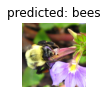

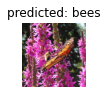

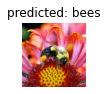

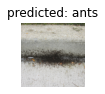

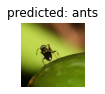

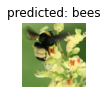

In [ ]:
visualize_model(model)

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
test_folder = '/content/drive/My Drive/hymenoptera_data/test'
testset = torchvision.datasets.ImageFolder(test_folder, data_transforms['test'])
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
# MUST EDIT
class_names = ['ants','bees']
# class_names = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']

In [ ]:
# attempt at output
import csv

model.eval()
with open(os.path.join(data_folder,'out.csv'), mode='w') as out_file:
  column_names = ['filename', 'category']
  writer = csv.DictWriter(out_file, fieldnames=column_names)
  writer.writeheader()

  with torch.no_grad():
      for i, (inputs, labels) in enumerate(testloader):
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          
          for j in range(inputs.size()[0]):
            # Retrieves file name
            sample_fname, _ = testloader.dataset.samples[i+j]
            # MUST EDIT TO REMOVE THE '/content/drive/My Drive/hymenoptera_data/test/ants/'
            fname = sample_fname[51:]
            print(fname, end='\n')
            print(class_names[preds[j]], end='\n')

            writer.writerow({'filename': fname, 'category': class_names[preds[j]]})

10308379_1b6c72e180.jpg
ants
11381045_b352a47d8c.jpg
ants
119785936_dd428e40c3.jpg
bees
147542264_79506478c2.jpg
ants
152286280_411648ec27.jpg
ants
17081114_79b9a27724.jpg
ants
35558229_1fa4608a7a.jpg
ants
57264437_a19006872f.jpg
ants
800px-Meat_eater_ant_qeen_excavating_hole.jpg
ants
8124241_36b290d372.jpg
ants
8398478_50ef10c47a.jpg
bees
94999827_36895faade.jpg
ants
10870992_eebeeb3a12.jpg
bees
144098310_a4176fd54d.jpg
bees
149973093_da3c446268.jpg
bees
151594775_ee7dc17b60.jpg
ants
26589803_5ba7000313.jpg
bees
44105569_16720a960c.jpg
bees
54736755_c057723f64.jpg
bees
57459255_752774f1b2.jpg
bees
59798110_2b6a3c8031.jpg
ants
65038344_52a45d090d.jpg
bees
6a00d8341c630a53ef00e553d0beb18834-800wi.jpg
bees
72100438_73de9f17af.jpg
bees
